# Neural Network

In [ ]:
batch_size = 32
nb_epoch = 2000
feature_col = [
    "coat", "D", "Rc", "l", "lu", "DN", "Lf", "Ds",
    "z", "Theta", "HRC"
] #mut be list
target_col = ["S"]
source_dir = "../catalog_data"
files = [
    "d1_soku.csv", #A
    "d2_soku.csv", #B
    "d3_soku.csv", #C
    #"d4_soku.csv", #D
    #"d5_soku.csv", #E
]
input_num = len(feature_col)
hidden_num = 16
output_num = len(target_col)

In [98]:
import torch
from torch import nn

from model import SimpleNN
from dataset import CatalogDataset

In [121]:
model = SimpleNN(
    input_num = input_num,
    hidden_num = hidden_num,
    output_num = output_num
)

In [122]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [123]:
dataset = CatalogDataset(
    src_dir = source_dir,
    feature_col = feature_col,
    targets = target_col,
    files = files
)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size = batch_size,
    shuffle = True
)

losses = []
for e in range(nb_epoch):
    epoch_loss = 0
    iter_count = 0
    for x, y in dataloader:
        iter_count += 1
        optimizer.zero_grad()
        
        pred = model(x)
        #print(pred.shape, y.shape)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    losses.append(epoch_loss / iter_count)
    if (e+1) % 100 == 0:
        print(e+1, losses[-1])

dataset shape x: torch.Size([3524, 11]), y: torch.Size([3524, 1])
100 0.0028837536999678894
200 0.0019244978496456636
300 0.0015986721610298028
400 0.001419560241432722
500 0.0012819402378423743
600 0.0012062225407692142
700 0.001151084303372143
800 0.0010814922001094321
900 0.0010448363673850173
1000 0.0009802928826822019
1100 0.0009336938229672661
1200 0.0009048267497459787
1300 0.0008758725577478741
1400 0.0008467291968167751
1500 0.0008486500220962691
1600 0.0008102294823484126
1700 0.0007934168755676732
1800 0.0007833116145087155
1900 0.0007730926767066079
2000 0.000766419703362411


In [124]:
#files = [
#    "d1_soku.csv", #A
    #"d2_soku.csv", #B
#]
dataset = dataset = CatalogDataset(
    src_dir = source_dir,
    feature_col = feature_col,
    targets = target_col,
    files = files
)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size = batch_size,
    shuffle = False
)
model.eval()
all_y = []
all_pred = []
with torch.no_grad():
    for x, y in dataloader:
        iter_count += 1
        pred = model(x)
        all_y.extend(y)
        all_pred.extend(pred)

dataset shape x: torch.Size([3524, 11]), y: torch.Size([3524, 1])


In [125]:
all_y = torch.Tensor(all_y)
all_pred = torch.Tensor(all_pred)

In [126]:
print(len(all_y), len(all_pred))

3524 3524


In [127]:
# reverse Scaling
all_y = torch.Tensor(all_y) * (dataset.trans.y_max - dataset.trans.y_min) + dataset.trans.y_min
all_pred = torch.Tensor(all_pred) * (dataset.trans.y_max - dataset.trans.y_min) + dataset.trans.y_min

In [106]:
import matplotlib.pyplot as plt

In [128]:
plt.rcParams["font.family"] = "Times New Roman" 
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

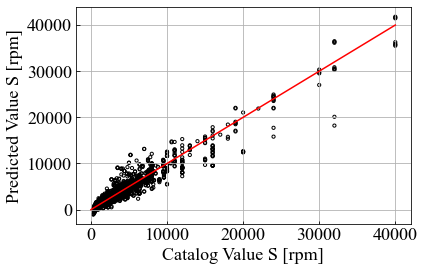

In [129]:
plt.figure()
plt.locator_params(axis='y',nbins=6)
plt.locator_params(axis='x',nbins=6)
plt.xlabel("Catalog Value S [rpm]", fontsize=18)
plt.ylabel("Predicted Value S [rpm]", fontsize=18)
plt.scatter(list(all_y), list(all_pred),
            s=10,
            facecolor='None',
            edgecolor="black",
           )
plt.plot((0, dataset.trans.y_max[0]), (0, dataset.trans.y_max[0]), c="red")
plt.grid()
plt.tick_params(labelsize=18)
plt.savefig("results/A-B-C_data_6_3.png", dpi=200, bbox_inches='tight', pad_inches=0.1)

In [130]:
from captum.attr import IntegratedGradients

In [131]:
print(dataset.targets.shape, dataset.features.shape)

torch.Size([3524, 1]) torch.Size([3524, 11])


In [60]:
torch.save(model.state_dict(), "weights/6_3_ABC_0_00054.pth")

In [132]:
ig = IntegratedGradients(model)
baseline = dataset.targets
"""
pred_all = []
with torch.no_grad():
    for i in range((len(dataset.features) + batch_size - 1) // batch_size):
        ed = (i+1)*batch_size
        if ed > len(dataset.features):
            ed = len(dataset.features)
        pred = model(dataset.features[i*batch_size : ed])
        pred_all.extend(pred)     
pred_all = torch.Tensor(pred_all)
"""
attributions = ig.attribute(
    dataset.features, 
    torch.zeros_like(dataset.features))

In [133]:
print(attributions.shape)

torch.Size([3524, 11])


In [134]:
attr_summary = attributions.mean(dim=0)

In [135]:
print(attr_summary)
print(feature_col)

tensor([ 0.0305, -0.2338,  0.0138, -0.1648, -0.3147, -0.0494, -0.2291, -0.0519,
        -0.0080, -0.0749, -0.0486], dtype=torch.float64)
['coat', 'D', 'Rc', 'l', 'lu', 'DN', 'Lf', 'Ds', 'z', 'Theta', 'HRC']


# Random Forest

In [141]:
import sklearn
from sklearn.ensemble import RandomForestRegressor

In [144]:
rf = RandomForestRegressor()
rf.fit(dataset.features, dataset.targets[:, 0])

RandomForestRegressor()

In [145]:
importance = rf.feature_importances_

In [156]:
pred = rf.predict(dataset.features)

In [158]:
pred[:10]

array([0.99798463, 0.79846328, 1.        , 0.79846328, 1.        ,
       0.79846328, 0.99596927, 0.79846328, 0.99798463, 0.79846328])

In [159]:
pred = torch.Tensor(pred) * (dataset.trans.y_max - dataset.trans.y_min) + dataset.trans.y_min
targets = torch.Tensor(dataset.targets) * (dataset.trans.y_max - dataset.trans.y_min) + dataset.trans.y_min

In [160]:
pred[:10]

tensor([39920., 32000., 40000., 32000., 40000., 32000., 39840., 32000., 39920.,
        32000.])

In [162]:
targets[:10]

tensor([[40000.],
        [32000.],
        [40000.],
        [32000.],
        [40000.],
        [32000.],
        [40000.],
        [32000.],
        [40000.],
        [32000.]])

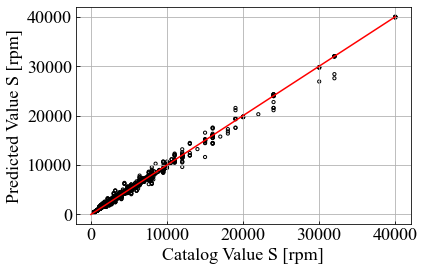

In [163]:
plt.figure()
plt.locator_params(axis='y',nbins=6)
plt.locator_params(axis='x',nbins=6)
plt.xlabel("Catalog Value S [rpm]", fontsize=18)
plt.ylabel("Predicted Value S [rpm]", fontsize=18)
plt.scatter(targets, pred,
            s=10,
            facecolor='None',
            edgecolor="black",
           )
plt.plot((0, dataset.trans.y_max[0]), (0, dataset.trans.y_max[0]), c="red")
plt.grid()
plt.tick_params(labelsize=18)
plt.savefig("results/A-B-C_data_rf_6_3.png", dpi=200, bbox_inches='tight', pad_inches=0.1)